<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
# import numpy as np
# import scipy.stats as stats
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# sns.set_style('whitegrid')

# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline

In [2]:
# pd.set_option('display.max_rows', 2000)
# pd.set_option('display.max_columns', 2000)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# A:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures, Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
# Load the data
df = pd.read_csv('./housing.csv')

In [5]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Looking at categorical values
def cat_exploration(column):
    return df[column].value_counts()

# Imputing the missing values
def cat_imputation(column, value):
    df.loc[df[column].isnull(),column] = value
    
# To check how many columns have missing values - this can be repeated to see the progress made
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

In [7]:
df[show_missing()].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
# check correlation with LotArea
df['LotFrontage'].corr(df['LotArea'])

0.4260950187718079

In [9]:
# improvement - and good enough for now
df['SqrtLotArea']=np.sqrt(df['LotArea'])
df['LotFrontage'].corr(df['SqrtLotArea'])

0.6020022167939362

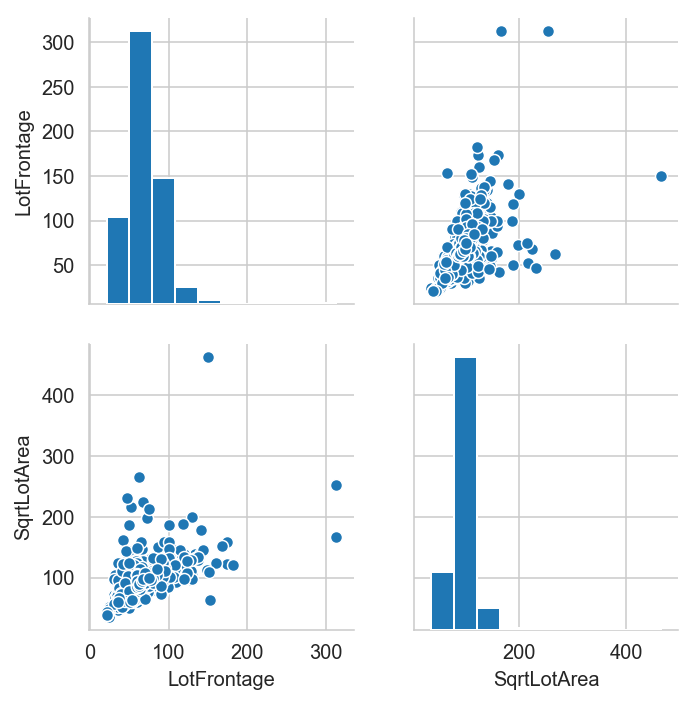

In [10]:
sns.pairplot(df[['LotFrontage','SqrtLotArea']].dropna())

In [11]:
cond = df['LotFrontage'].isnull()
df.LotFrontage[cond]=df.SqrtLotArea[cond]

C:\Users\Ayden\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# This column is not needed anymore
del df['SqrtLotArea']

In [13]:
cat_exploration('Alley')

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [14]:
# I assume empty fields here mean no alley access
cat_imputation('Alley','None')

In [15]:
df[['MasVnrType','MasVnrArea']][df['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [16]:
cat_exploration('MasVnrType')

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [17]:
cat_imputation('MasVnrType', 'None')
cat_imputation('MasVnrArea', 0.0)

In [18]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
df[basement_cols][df['BsmtQual'].isnull()==True]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
17,NaN,NaN,NaN,NaN,NaN,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0
182,NaN,NaN,NaN,NaN,NaN,0,0
259,NaN,NaN,NaN,NaN,NaN,0,0
342,NaN,NaN,NaN,NaN,NaN,0,0
362,NaN,NaN,NaN,NaN,NaN,0,0
371,NaN,NaN,NaN,NaN,NaN,0,0


In [19]:
for cols in basement_cols:
    if 'FinSF'not in cols:
        cat_imputation(cols,'None')

In [20]:
cat_exploration('Electrical')

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [21]:
# Impute most frequent value
cat_imputation('Electrical','SBrkr')

In [22]:
cat_exploration('FireplaceQu')

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [23]:
df['Fireplaces'][df['FireplaceQu'].isnull()==True].describe()

count    690.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Fireplaces, dtype: float64

In [24]:
cat_imputation('FireplaceQu','None')

In [25]:
pd.crosstab(df.Fireplaces, df.FireplaceQu)

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


In [26]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
df[garage_cols][df['GarageType'].isnull()==True]

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


In [27]:
#Garage Imputation
for cols in garage_cols:
    if df[cols].dtype==np.object:
        cat_imputation(cols,'None')
    else:
        cat_imputation(cols, 0)

In [28]:
cat_exploration('PoolQC')

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [29]:
df['PoolArea'][df['PoolQC'].isnull()==True].describe()

count    1453.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: PoolArea, dtype: float64

In [30]:
cat_imputation('PoolQC', 'None')

In [31]:
cat_imputation('Fence', 'None')

In [32]:
cat_imputation('MiscFeature', 'None')

In [33]:
df[show_missing()].isnull().sum()

Series([], dtype: float64)

In [34]:
df.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [35]:
df.drop(df[df['MSZoning'] == 'FV'].index, inplace=True)
df.drop(df[df['MSZoning'] == 'C (all)'].index, inplace=True)

In [36]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [37]:
ids = df["Id"]
df.drop(columns = ["Id"], axis = 1, inplace = True)

In [38]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [39]:
df.MSSubClass.replace({20:'1-STORY 1946 & NEWER ALL STYLES', 30:'1-STORY 1945 & OLDER', 40:'1-STORY W/FINISHED ATTIC ALL AGES'
                       , 45:'1-1/2 STORY - UNFINISHED ALL AGES', 50:'1-1/2 STORY FINISHED ALL AGES', 60:'2-STORY 1946 & NEWER'
                       , 70:'2-STORY 1945 & OLDER', 75:'2-1/2 STORY ALL AGES', 80:'SPLIT OR MULTI-LEVEL', 85:'SPLIT FOYER'
                       , 90:'DUPLEX - ALL STYLES AND AGES', 120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
                       , 150:'1-1/2 STORY PUD - ALL AGES', 160:'2-STORY PUD - 1946 & NEWER', 180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
                       , 190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}, inplace = True)

In [40]:
df.MSSubClass

0                                    2-STORY 1946 & NEWER
1                         1-STORY 1946 & NEWER ALL STYLES
2                                    2-STORY 1946 & NEWER
3                                    2-STORY 1945 & OLDER
4                                    2-STORY 1946 & NEWER
5                           1-1/2 STORY FINISHED ALL AGES
6                         1-STORY 1946 & NEWER ALL STYLES
7                                    2-STORY 1946 & NEWER
8                           1-1/2 STORY FINISHED ALL AGES
9               2 FAMILY CONVERSION - ALL STYLES AND AGES
10                        1-STORY 1946 & NEWER ALL STYLES
11                                   2-STORY 1946 & NEWER
12                        1-STORY 1946 & NEWER ALL STYLES
13                        1-STORY 1946 & NEWER ALL STYLES
14                        1-STORY 1946 & NEWER ALL STYLES
15                      1-1/2 STORY - UNFINISHED ALL AGES
16                        1-STORY 1946 & NEWER ALL STYLES
17            

In [41]:
df.shape

(1385, 80)

In [42]:
# Selecting all the features I want to use in the model with some common sense based on data description.txt
# df_nonreno = df[['SalePrice', 'GrLivArea', 'GarageCars', 'GarageArea', '1stFlrSF', 'TotalBsmtSF', 'YrSold']]
df_nonreno = df[['SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape'
                 , 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2'
                 , 'BldgType', 'HouseStyle', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinSF1'
                 , 'TotalBsmtSF', 'Heating', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath'
                 , 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea', 'PavedDrive'
                 , 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature'
                 , 'MiscVal', 'SaleType', 'SaleCondition', 'YrSold']]

In [43]:
# creating dummies on the categorical data
df_dummied = pd.get_dummies(df_nonreno)

In [44]:
# checking the shape of the new df
df_dummied.shape

(1385, 172)

In [45]:
# taking a look at the columns of the new df
df_dummied.columns

Index(['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=172)

In [46]:
# splitting dataset into test and train based on year sold
df_train = df_dummied[df_dummied['YrSold'] < 2010]
df_test = df_dummied[df_dummied['YrSold'] == 2010]

In [47]:
# taking a look at the train df set
df_train

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,65.000000,8450,196.0,706,856,856,854,1710,1,...,0,0,0,1,0,0,0,0,1,0
1,181500,80.000000,9600,0.0,978,1262,1262,0,1262,0,...,0,0,0,1,0,0,0,0,1,0
2,223500,68.000000,11250,162.0,486,920,920,866,1786,1,...,0,0,0,1,0,0,0,0,1,0
3,140000,60.000000,9550,0.0,216,756,961,756,1717,1,...,0,0,0,1,1,0,0,0,0,0
4,250000,84.000000,14260,350.0,655,1145,1145,1053,2198,1,...,0,0,0,1,0,0,0,0,1,0
5,143000,85.000000,14115,0.0,732,796,796,566,1362,1,...,0,0,0,1,0,0,0,0,1,0
6,307000,75.000000,10084,186.0,1369,1686,1694,0,1694,1,...,0,0,0,1,0,0,0,0,1,0
7,200000,101.892100,10382,240.0,859,1107,1107,983,2090,1,...,0,0,0,1,0,0,0,0,1,0
8,129900,51.000000,6120,0.0,0,952,1022,752,1774,0,...,0,0,0,1,1,0,0,0,0,0
9,118000,50.000000,7420,0.0,851,991,1077,0,1077,1,...,0,0,0,1,0,0,0,0,1,0


In [48]:
# df test set needs index reset
df_test = df_test.reset_index()

In [49]:
# checking if the index has been correctly put in
df_test

,index,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,16,149000,106.023582,11241,180.0,578,1004,1004,0,1004,...,0,0,0,1,0,0,0,0,1,0
1,24,154000,90.807489,8246,0.0,188,1060,1060,0,1060,...,0,0,0,1,0,0,0,0,1,0
2,26,134800,60.000000,7200,0.0,234,900,900,0,900,...,0,0,0,1,0,0,0,0,1,0
3,27,306000,98.000000,11478,200.0,1218,1704,1704,0,1704,...,0,0,0,1,0,0,0,0,1,0
4,33,165500,70.000000,10552,0.0,1018,1398,1700,0,1700,...,0,0,0,1,0,0,0,0,1,0
5,38,109000,68.000000,7922,0.0,731,1057,1057,0,1057,...,0,0,0,1,1,0,0,0,0,0
6,45,319900,61.000000,7658,412.0,456,1752,1752,0,1752,...,0,0,0,1,0,0,0,0,1,0
7,52,110000,110.000000,8472,0.0,104,816,816,0,816,...,0,0,0,1,0,0,0,0,1,0
8,63,140000,50.000000,10300,0.0,0,576,902,808,1710,...,0,0,0,1,0,0,0,0,1,0
9,66,180000,141.067360,19900,287.0,912,1947,2207,0,2207,...,0,0,0,1,0,0,0,0,1,0


In [50]:
# droping the index column since we don't need it anymore
df_test = df_test.drop(['index'], axis = 1)

In [51]:
# dropping the year sold column as it is not a feature we want in the modelling process
df_test = df_test.drop(['YrSold'], axis=1)
df_train = df_train.drop(['YrSold'], axis=1)

In [52]:
# taking a look at correlation to sales price for the features overall
df.corr()['SalePrice'].sort_values(ascending=False).head(20)

SalePrice       1.000000
OverallQual     0.790986
GrLivArea       0.708499
GarageCars      0.640954
GarageArea      0.629048
TotalBsmtSF     0.617536
1stFlrSF        0.617059
FullBath        0.557077
TotRmsAbvGrd    0.536250
YearBuilt       0.517466
MasVnrArea      0.508017
YearRemodAdd    0.499208
Fireplaces      0.471702
BsmtFinSF1      0.394510
WoodDeckSF      0.325670
OpenPorchSF     0.324483
2ndFlrSF        0.318834
LotFrontage     0.291479
HalfBath        0.283088
LotArea         0.270955
Name: SalePrice, dtype: float64

In [53]:
# X = df_dummied[['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']]
# X = df_train.values
# y = y.values
y = df_train['SalePrice']
df_train = df_train.drop(['SalePrice'], axis=1)
y_2 = df_test['SalePrice']
df_test = df_test.drop(['SalePrice'], axis=1)

In [54]:
# # # Train_Test split X and y
# X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)
X_train = df_train.values
y_train = y.values
X_test = df_test.values
y_test = y_2

# standardize x variables
ss = StandardScaler()
Xs = ss.fit_transform(X_train)
Xst = ss.fit_transform(X_test)

In [55]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1221, 170)
(1221,)
(164, 170)
(164,)


In [56]:
# # # Linear regression
# lm = LinearRegression()
# lmfit = lm.fit(X_train, y_train)

In [57]:
# # # predict y values based on fitted model
# lmpredict = lm.predict(X_test)

# print('Accuracy:', lmfit.score(X_test, y_test)*100)
# print('Median absolute error:', median_absolute_error(y_test, lmpredict))

In [58]:
# k = 13 #number of variables for heatmap
# cols = corrhouse.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(house[cols].values.T)

In [59]:
# MLR model prediction to check R2
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     44.28
Date:                Wed, 16 Jan 2019   Prob (F-statistic):               0.00
Time:                        11:46:31   Log-Likelihood:                -14324.
No. Observations:                1221   AIC:                         2.894e+04
Df Residuals:                    1074   BIC:                         2.969e+04
Df Model:                         146                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -159.5161     48.491     -3.290      0.001    -254.663     -64.369
x2             0.7473      0.152      4.923      0.000       0.449       1.045
x3            31.2858      9.155      3.417      0.001      13.321      49.250
x4             9.6215      3.378      2.848      0.004       2.994      16.249
x5             0.6244      5.884      0.106      0.916     -10.921      12.170
x6             6.2296     27.791      0.224      0.823     -48.301      60.760
x7            27.7910     26.662      1.042      0.297     -24.525      80.107
x8            49.0901     27.427      1.790      0.074      -4.726     102.906
x9          8190.9753   2708.058      3.025      0.003    2877.291    1.35e+04
x10         8621.5072   4119.601      2.093      0.037     538.127    1.67e+04
x11         8694.7081   3155.338      2.756      0.006    2503.382    1.49e+04
x12         7347.5522   3123.401      2.352      0.019    1218.892    1.35e+04
x13          207.0910   1294.671      0.160      0.873   -2333.280    2747.462
x14         5500.6477   1969.518      2.793      0.005    1636.109    9365.187
x15         1.457e+04   3250.593      4.482      0.000    8189.838    2.09e+04
x16           -1.4703     11.154     -0.132      0.895     -23.357      20.417
x17           18.5830      8.774      2.118      0.034       1.367      35.799
x18           19.3053     17.466      1.105      0.269     -14.966      53.577
x19           -1.4459     17.806     -0.081      0.935     -36.384      33.492
x20           65.4115     31.679      2.065      0.039       3.252     127.571
x21           64.4094     18.267      3.526      0.000      28.566     100.253
x22           28.7130     25.498      1.126      0.260     -21.318      78.744
x23            4.7449     13.671      0.347      0.729     -22.080      31.570
x24        -9810.5906   2.98e+04     -0.329      0.742   -6.84e+04    4.87e+04
x25         1.502e+04   1.21e+04      1.242      0.214   -8710.074    3.88e+04
x26         8855.7374   9927.917      0.892      0.373   -1.06e+04    2.83e+04
x27         1.664e+04   8599.683      1.935      0.053    -232.501    3.35e+04
x28         -1.33e+04   1.72e+04     -0.771      0.441   -4.71e+04    2.05e+04
x29        -1.277e+04   2.64e+04     -0.484      0.628   -6.45e+04     3.9e+04
x30         2.471e+04   3.37e+04      0.733      0.463   -4.14e+04    9.08e+04
x31         1096.0362   1.95e+04      0.056      0.955   -3.72e+04    3.94e+04
x32          1.68e+04   1.01e+04      1.667      0.096   -2978.978    3.66e+04
x33         8435.3063   9819.844      0.859      0.391   -1.08e+04    2.77e+04
x34        -2.665e+04      2e+04     -1.332      0.183   -6.59e+04    1.26e+04
x35        -5451.8359   5317.281     -1.025      0.305   -1.59e+04    4981.602
x36        -3.049e+04   2.31e+04     -1.318      0.188   -7.59e+04    1.49e+04
x3

In [60]:
# predicting the price using the test set of features
predict_y = model.predict(X_test)

In [61]:
# transforming the array into a series
predict_y = pd.Series(predict_y)

In [62]:
# calculating the variance between the test and prediction
df_residual = predict_y - y_test

In [63]:
df_residual.head(5)

0    -1438.116919
1   -16438.710476
2     1778.897388
3     2339.135681
4    29861.583688
dtype: float64

In [64]:
# creating dataframe of prediction residual
test_result = pd.DataFrame()
test_result['predict_y'] = predict_y
test_result['y_test'] = y_test
test_result['residual'] = df_residual

# creating dataframe of train residual

predict_y_train = model.predict(X_train)

train_result = pd.DataFrame()
train_result['predict_y'] = predict_y_train
train_result['y_train'] = y_train

df_residual_train = predict_y_train - y_train
train_result['residual'] = df_residual_train

C:\Users\Ayden\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Ayden\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


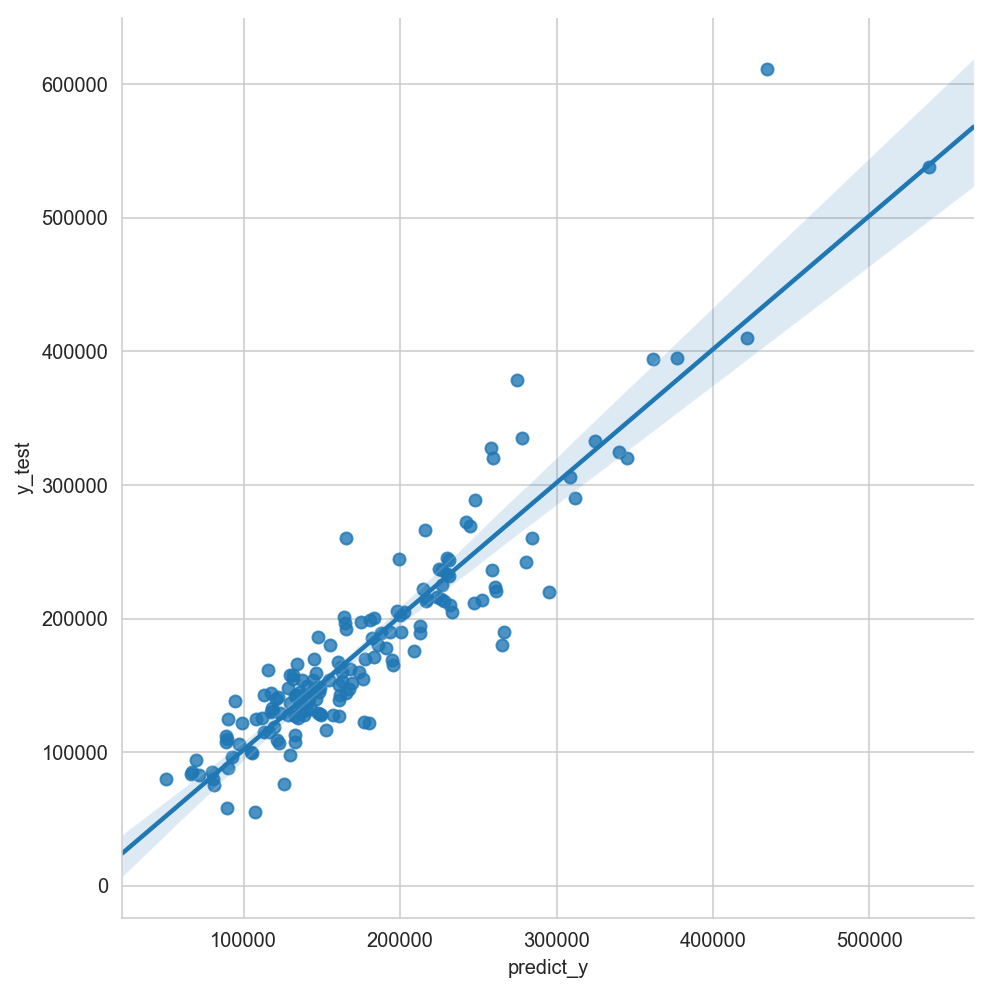

In [65]:
# plotting to take a look at the 2 results
sns.lmplot(x='predict_y', y='y_test', data=test_result, size=7)

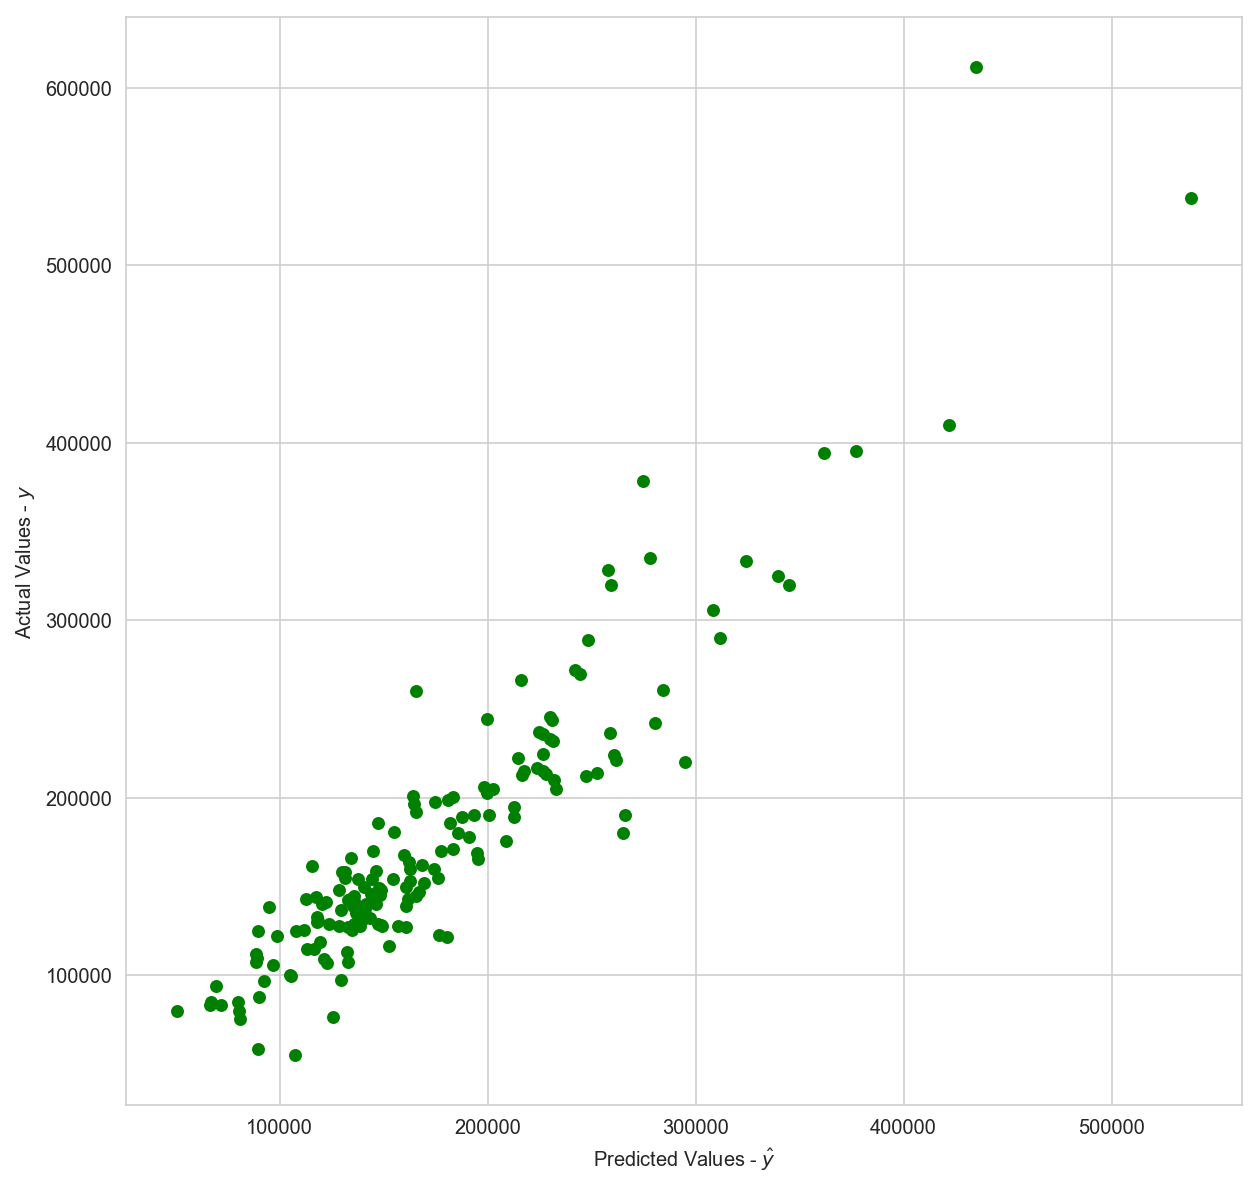

MSE: 942982796.0813457


In [68]:
# Plotting the model
plt.figure(figsize=(10,10))
plt.scatter(predict_y, y_test, s=30, c='g', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

print ("MSE:", mean_squared_error(y_test, predict_y))

In [108]:
#ridge
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
predictions = cross_val_predict(ridge, Xst, y_test, cv=10)

ridge_scores = cross_val_score(ridge, Xs, y_train, cv=10)

print('Mean CrossVal R2:', np.mean(ridge_scores))
print('Std CrossVal R2:', np.std(ridge_scores))
print('Median absolute error:', median_absolute_error(y_test, predictions))

Mean CrossVal R2: 0.7935693821104037
Std CrossVal R2: 0.09542152532921509
Median absolute error: 16961.840009357693


In [94]:
# Lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y_train, cv=10)
predictions = cross_val_predict(lasso, Xst, y_test, cv=10)

print('Mean CrossVal R2:', np.mean(lasso_scores))
print('Std CrossVal R2:', np.std(lasso_scores))
print('Median absolute error:', median_absolute_error(y_test, predictions))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean CrossVal R2: 0.7837069880148366
Std CrossVal R2: 0.1103410318198386
Median absolute error: 16855.15936886869


In [74]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

print('Gradient Boosting R2: %.4f' % model.score(X_test, y_test))

Gradient Boosting R2: 0.8514


In [75]:
feature_labels = df_train.columns
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))
# feature_indexes_by_importance

Heating_Floor-0.00%
BldgType_2fmCon-0.00%
Neighborhood_BrDale-0.00%
Neighborhood_Blueste-0.00%
Neighborhood_Blmngtn-0.00%
LandSlope_Gtl-0.00%
LotConfig_FR3-0.00%
HouseStyle_2.5Unf-0.00%
Neighborhood_ClearCr-0.00%
Utilities_NoSeWa-0.00%
LandContour_Lvl-0.00%
LandContour_Low-0.00%
BsmtExposure_None-0.00%
Condition1_RRNn-0.00%
LotShape_IR1-0.00%
Alley_None-0.00%
Alley_Grvl-0.00%
Utilities_AllPub-0.00%
Neighborhood_CollgCr-0.00%
Condition2_RRNn-0.00%
BsmtExposure_Mn-0.00%
Condition1_RRNe-0.00%
Condition1_RRAn-0.00%
Condition1_RRAe-0.00%
Condition1_PosN-0.00%
Condition1_PosA-0.00%
HouseStyle_SLvl-0.00%
Condition2_Feedr-0.00%
Condition2_PosN-0.00%
Neighborhood_Sawyer-0.00%
Condition2_RRAe-0.00%
Foundation_Slab-0.00%
Neighborhood_NPkVill-0.00%
Condition2_RRAn-0.00%
Foundation_Stone-0.00%
Foundation_Wood-0.00%
Neighborhood_IDOTRR-0.00%
Neighborhood_Gilbert-0.00%
Street_Pave-0.00%
Street_Grvl-0.00%
Condition2_Artery-0.00%
Heating_GasW-0.00%
MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES-0.00%
Hou

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [76]:
# A:
# setting the features that are renovatable based on data description.txt
df_reno = df[['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual'
             , 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'
             , 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual'
             , 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'YrSold']]

In [77]:
df_reno.head(5)

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtQual,BsmtCond,...,KitchenAbvGr,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,YrSold
0,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,...,1,Gd,Typ,None,RFn,TA,TA,None,None,2008
1,6,8,Gable,CompShg,MetalSd,MetalSd,TA,TA,Gd,TA,...,1,TA,Typ,TA,RFn,TA,TA,None,None,2007
2,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,...,1,Gd,Typ,TA,RFn,TA,TA,None,None,2008
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,TA,Gd,...,1,Gd,Typ,Gd,Unf,TA,TA,None,None,2006
4,8,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,...,1,Gd,Typ,TA,RFn,TA,TA,None,None,2008


In [78]:
df_reno.columns

Index(['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'YrSold'],
      dtype='object')

In [79]:
test_result.isnull().sum()

predict_y    0
y_test       0
residual     0
dtype: int64

In [80]:
df_reno_dummied = pd.get_dummies(df_reno)

In [81]:
df_reno_train = df_reno_dummied[df_reno_dummied['YrSold'] < 2010]
df_reno_test = df_reno_dummied[df_reno_dummied['YrSold'] == 2010]

# dropping the year sold column as it is not a feature we want in the modelling process
df_test = df_reno_test.drop(['YrSold'], axis=1)
df_train = df_reno_train.drop(['YrSold'], axis=1)

In [82]:
df_reno_train.head()

,OverallQual,OverallCond,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,YrSold,RoofStyle_Flat,RoofStyle_Gable,...,GarageCond_TA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None
0,7,5,0,150,0,3,1,2008,0,1,...,1,0,0,0,1,0,0,0,0,1
1,6,8,0,284,0,3,1,2007,0,1,...,1,0,0,0,1,0,0,0,0,1
2,7,5,0,434,0,3,1,2008,0,1,...,1,0,0,0,1,0,0,0,0,1
3,7,5,0,540,0,3,1,2006,0,1,...,1,0,0,0,1,0,0,0,0,1
4,8,5,0,490,0,4,1,2008,0,1,...,1,0,0,0,1,0,0,0,0,1


In [83]:
df_reno_test = df_reno_test.reset_index()

In [84]:
df_reno_test = df_reno_test.drop(['index'], axis=1)
df_reno_test.head(5)

,OverallQual,OverallCond,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,YrSold,RoofStyle_Flat,RoofStyle_Gable,...,GarageCond_TA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None
0,6,7,0,426,0,2,1,2010,0,1,...,1,0,0,0,1,0,0,0,0,1
1,5,8,668,204,0,3,1,2010,0,1,...,1,0,0,0,1,0,0,1,0,0
2,5,7,486,180,0,3,1,2010,0,1,...,1,0,0,0,1,0,0,0,0,1
3,8,5,0,486,0,3,1,2010,0,1,...,1,0,0,0,1,0,0,0,0,1
4,5,5,0,380,0,4,1,2010,0,0,...,1,0,0,0,1,0,0,0,0,1


In [86]:
# # # Train_Test split X and y
# X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)
X_train_2 = df_reno_train
y_train_2 = train_result['residual']
X_test_2 = df_reno_test
y_test_2 = test_result['residual']

# standardize x variables
ss = StandardScaler()
Xs_2 = ss.fit_transform(X_train_2)
Xst_2 = ss.fit_transform(X_test_2)

In [87]:
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(1221, 140)
(1221,)
(164, 140)
(164,)


In [110]:
#ridge
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_2, y_train_2)

ridge = Ridge(alpha=optimal_ridge.alpha_)
predictions = cross_val_predict(ridge, Xst, y_test_2, cv=10)

ridge_scores = cross_val_score(ridge, Xs_2, y_train_2, cv=10)

print('Mean CrossVal R2:', np.mean(ridge_scores))
print('Std CrossVal R2:', np.std(ridge_scores))
print('Median absolute error:', median_absolute_error(y_test_2, predictions))

Mean CrossVal R2: 0.08183522282402887
Std CrossVal R2: 0.08228230853126639
Median absolute error: 16781.12671084726


In [103]:
# Lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_2, y_train_2)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_2, y_train_2, cv=10)
predictions = cross_val_predict(lasso, Xst_2, y_test_2, cv=10)

print(predictions.shape)
print(y_test_2.shape)
print('Mean CrossVal R2:', np.mean(lasso_scores))
print('Std CrossVal R2:', np.std(lasso_scores))
print('Median absolute error:', median_absolute_error(y_test_2, predictions))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

(164,)
(164,)
Mean CrossVal R2: 0.06763608288727019
Std CrossVal R2: 0.15751917400229917
Median absolute error: 16551.938294275093


In [90]:
#gradient
model = ensemble.GradientBoostingRegressor()
model.fit(X_train_2, y_train_2)

print('Gradient Boosting R2: %.4f' % model.score(X_test_2, y_test_2))

Gradient Boosting R2: 0.2537


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: